In [24]:

#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import models
from datasets import MelDataset, vctkDataset

# root path
os.chdir('/mnt/work/')

# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/monkey/dataset6_length.yaml" 
model_config_path = "./Animal/configs/monkey/model2.yaml"

# model path
model_path = './Animal/output/monkey'
exp_name = 'VAEbase-class_indi_4-c_80.0_1.2-i_5.0_100.0'
checkpoint = "45000.pth.tar"

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# ------------------------------------------------------------------------

# dataset
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
used_key = [[
              'calltype_1',
              'calltype_2',
              'calltype_3',
              'calltype_4',
              'calltype_5',
              'calltype_6',
              # 'calltype_7',
              # 'calltype_8',
              # 'calltype_9',
              # 'calltype_10'
                ],
                [
                'twin_1_0',
                'twin_1_1',
                'twin_2_2',
                'twin_2_3',
                'twin_3_4',
                'twin_3_5',
                'twin_4_6',
                'twin_4_7',
                # 'twin_5_8',
                # 'twin_5_9'
                  ]]
analy_set = MelDataset(dataset_config, used_key = used_key, subset='test')


analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)


# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, indi_mel, cID, ctID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('ctID_counts',f"{element}: {count}")
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    


dataset marmoset loading...
Dict_1 ['calltype_1', 'calltype_2', 'calltype_3', 'calltype_4', 'calltype_5', 'calltype_6']
Dict_2 ['twin_1_0', 'twin_1_1', 'twin_2_2', 'twin_2_3', 'twin_3_4', 'twin_3_5', 'twin_4_6', 'twin_4_7']


100%|██████████| 6415/6415 [01:47<00:00, 59.73it/s]

ctID_counts 1: 2297
ctID_counts 2: 3433
ctID_counts 3: 246
ctID_counts 4: 99
ctID_counts 5: 60
ctID_counts 6: 280
cID_counts 0: 1769
cID_counts 1: 845
cID_counts 2: 1706
cID_counts 3: 567
cID_counts 4: 643
cID_counts 5: 365
cID_counts 6: 327
cID_counts 7: 193


In [25]:
print(len(total_z_con_mu))
print(total_z_indi[0].shape)

6415
(1, 128)


In [26]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

data_2d = tsne.fit_transform(total_z_con_1D) # cnontent



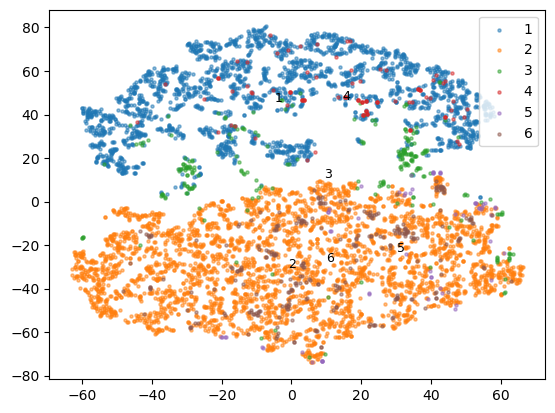

In [27]:

# Get unique labels
used_label = total_ctID
unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

    # 计算每个类别的中心点坐标
    centroid = np.mean(data_for_label, axis=0)
    # 在中心点上添加标签
    plt.text(centroid[0], centroid[1], str(label), fontsize=9, color='black', ha='center', va='center')
    
    
# Add a legend
plt.legend()
plt.show()

In [28]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi

total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()
total_indi = np.hstack((total_z_indi_mu, total_z_indi_log_std))

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d = tsne.fit_transform(total_z_indi_mu)



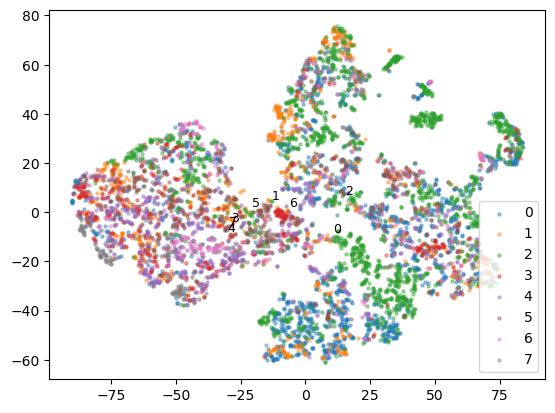

In [29]:

# Get unique labels
used_label = total_cID
unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.4, s=5)
    
    # 计算每个类别的中心点坐标
    centroid = np.mean(data_for_label, axis=0)
    # 在中心点上添加标签
    plt.text(centroid[0], centroid[1], str(label), fontsize=9, color='black', ha='center', va='center')
    

# Add a legend
plt.legend()
plt.show()